In [1]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from util import calc_ground_truth_constraints, constraint_matrix_to_rules, RuleClassifier
from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
shap.initjs()
%matplotlib inline

# Make Task

In [2]:
feature_names = np.array(['x1', 'x2'])
feature_precisions = [1, 1]

In [3]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X *= 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
lm = LogisticRegression()
lm.fit(X_train, y_train)
clf_a = lm

clf_b = LogisticRegression()
X2 = X.copy()
X2[:, 0] = 0
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.5, random_state=0)
clf_b.fit(X2_train, y2_train)

X_explain = X_test
y_explain = y_test

#with open('data/task.pickle', 'wb') as f:
#    pickle.dump((clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions), f)

In [4]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions = pickle.load(f)

In [5]:
print(classification_report(clf_a.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        66
           1       0.92      0.85      0.88        84

    accuracy                           0.87       150
   macro avg       0.87      0.88      0.87       150
weighted avg       0.88      0.87      0.87       150



In [6]:
print(classification_report(clf_b.predict(X2_test), y2_test))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82        63
           1       0.91      0.80      0.85        87

    accuracy                           0.84       150
   macro avg       0.84      0.85      0.84       150
weighted avg       0.85      0.84      0.84       150



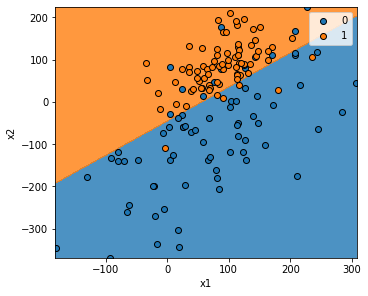

In [7]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
plot_decision_boundary(X_explain, y_explain, feature_names=feature_names,
                       predict=clf_a.predict, class_names=clf_a.classes_,
                       fig=fig, ax=ax)

In [8]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


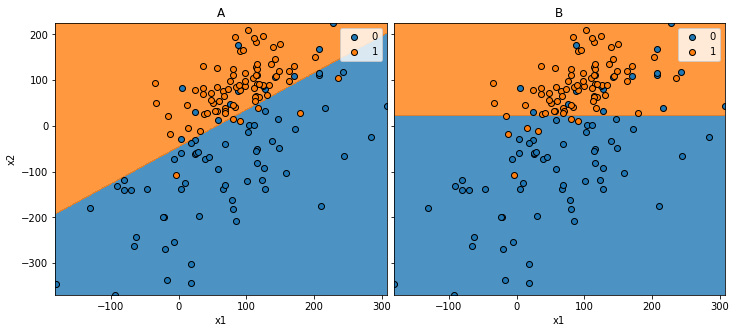

In [9]:
comparer.plot_individual_clf_decision_boundaries(X_explain, y_true=y_explain, kind='label')
plt.savefig('figures/b-ignores-feature-decision-boundaries-indiv.pdf', bbox_inches='tight', pad_inches=0)

In [10]:
clf_a.coef_, clf_a.intercept_

(array([[-0.02339328,  0.02894723]]), array([1.31734334]))

In [11]:
clf_b.coef_, clf_b.intercept_

(array([[0.        , 0.01712693]]), array([-0.37894697]))

In [12]:
x2_lim = -clf_b.intercept_[0]/clf_b.coef_[0][1]
x2_lim

22.125795775193605

In [13]:
x1_where_x2_crosses = (-clf_a.intercept_[0] - clf_a.coef_[0][1]*x2_lim)/clf_a.coef_[0][0]
x1_where_x2_crosses

83.69171686589276

In [14]:
intercept = -clf_a.intercept_[0]/clf_a.coef_[0][1]
intercept

-45.508443860900975

In [15]:
slope = -clf_a.coef_[0][0]/clf_a.coef_[0][1]
slope

0.8081354065716131

A logistic regression model discriminates at 0, therefore the decision boundary is given by the function $\beta_0 + \beta_1 x_1 + \beta_2 x_2 = 0$

The decision boundary for A can be expressed as a function of $x_1$: $f(x_1) = -\frac{\beta_0}{\beta_2} - \frac{\beta_1}{\beta_2}x_1$

Since for B it is true that $\beta_1=0$, then the decision boundary is given by $x_2^*=\frac{-\beta_0}{\beta_2}$

In [16]:
rules_01 = [f'x1 > {x1_where_x2_crosses} and {x2_lim} < x2 <= {intercept} + {slope} * x1']
rules_01

['x1 > 83.69171686589276 and 22.125795775193605 < x2 <= -45.508443860900975 + 0.8081354065716131 * x1']

In [17]:
rules_10 = [f'x1 <= {x1_where_x2_crosses} and {intercept} + {slope} * x1 < x2 <= {x2_lim}']
rules_10

['x1 <= 83.69171686589276 and -45.508443860900975 + 0.8081354065716131 * x1 < x2 <= 22.125795775193605']

In [18]:
def calc_01_x2_boundaries(x1):
    if x1 <= x1_where_x2_crosses:
        raise Exception('invalid x1 value')
    lower_boundary = x2_lim
    upper_boundary = intercept + slope * x1
    return lower_boundary, upper_boundary

In [19]:
def calc_01_x1_boundaries(x2):
    if x2 <= x2_lim:
        raise Exception('invalid x2 value')
    lower_boundary = (x2 - intercept)/slope
    upper_boundary = np.nan
    return lower_boundary, upper_boundary

In [20]:
def calc_10_x2_boundaries(x1):
    if x1 > x1_where_x2_crosses:
        raise Exception('invalid x1 value')
    lower_boundary = intercept + slope * x1
    upper_boundary = x2_lim
    return lower_boundary, upper_boundary

In [21]:
def calc_10_x1_boundaries(x2):
    if x2 > x2_lim:
        raise Exception('invalid x2 value')
    lower_boundary = np.nan
    upper_boundary = (x2 - intercept)/slope
    return lower_boundary, upper_boundary

In [22]:
rclf = RuleClassifier(feature_names, rules_01)

In [23]:
calc_01_x2_boundaries(200)

(22.125795775193605, 116.11863745342166)

In [24]:
X_test = [[200, 110]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [25]:
X_test = [[200, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [26]:
calc_01_x1_boundaries(109)

(191.19128131803885, nan)

In [27]:
X_test = [[199, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [28]:
X_test = [[200, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [29]:
rclf = RuleClassifier(feature_names, rules_10)

In [30]:
calc_10_x2_boundaries(0)

(-45.508443860900975, 22.125795775193605)

In [31]:
X_test = [[0, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [32]:
X_test = [[0, -39]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [33]:
calc_10_x1_boundaries(-38)

(nan, 9.291071520742252)

In [34]:
X_test = [[0, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [35]:
X_test = [[1, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

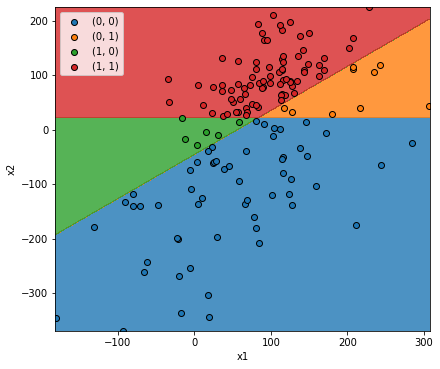

In [36]:
comparer.plot_decision_boundaries(X_explain)
plt.savefig('figures/b-ignores-feature-decision-boundaries-diffclf.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


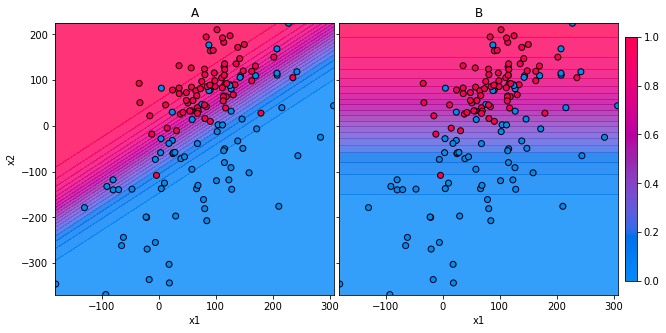

In [37]:
comparer.plot_individual_clf_decision_boundaries(X_explain, y_true=y_explain, kind='proba')
plt.savefig('figures/b-ignores-feature-decision-boundaries-indiv-proba.pdf', bbox_inches='tight', pad_inches=0)

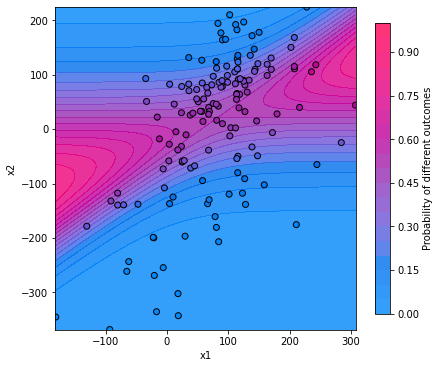

In [38]:
comparer.plot_decision_boundaries(X_explain, kind='proba', type='bin-diffclf')

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


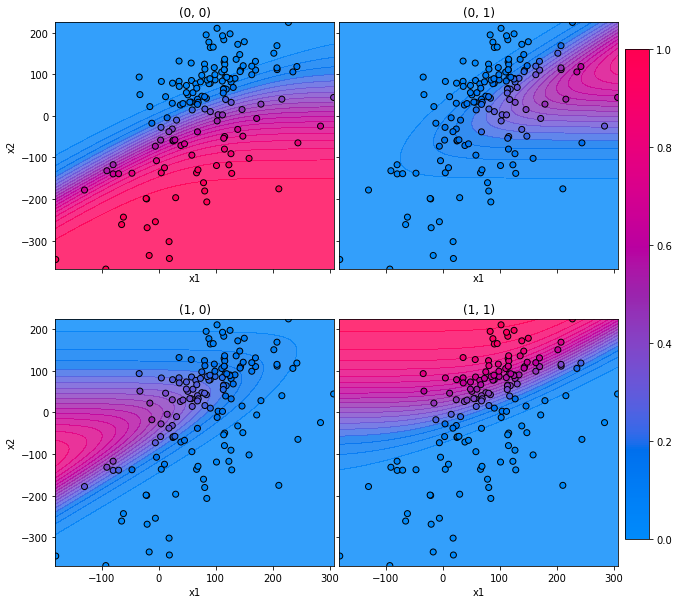

In [39]:
comparer.plot_decision_boundaries(X_explain, kind='proba', type='mclass-diffclf')
plt.savefig('figures/b-ignores-feature-decision-boundaries-diffclf-mclass-proba.pdf', bbox_inches='tight', pad_inches=0)

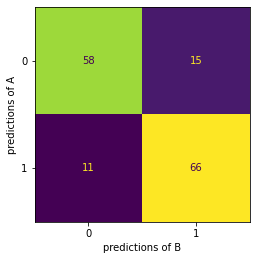

In [40]:
comparer.plot_confusion_matrix(X_train)

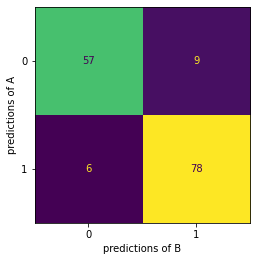

In [41]:
comparer.plot_confusion_matrix(X_explain)
plt.savefig('figures/b-ignores-feature-cm.pdf', bbox_inches='tight', pad_inches=0)

# Test Set

In [42]:
X_explain_test, _ = make_blobs(n_samples=10000, centers=1, cluster_std=100, random_state=2)
X_explain_test[:, 0] += x1_where_x2_crosses
X_explain_test[:, 1] += x2_lim
y_explain_test = comparer.predict_mclass_diff(X_explain_test)
with open('data/test.pickle', 'wb') as f:
    pickle.dump((X_explain_test, y_explain_test), f)

In [42]:
with open('data/test.pickle', 'rb') as f:
    X_explain_test, y_explain_test = pickle.load(f)

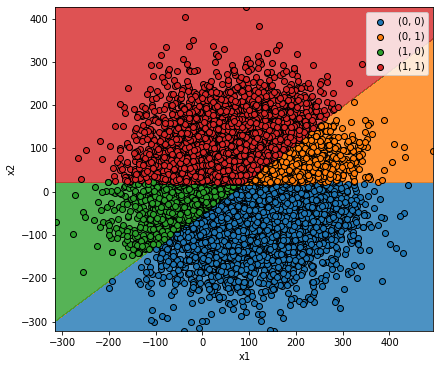

In [43]:
comparer.plot_decision_boundaries(X_explain_test)
plt.savefig('figures/bign-scatter-test.pdf', bbox_inches='tight', pad_inches=0)

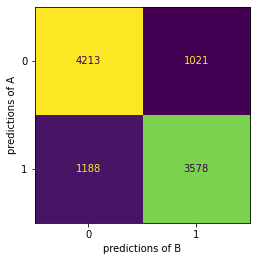

In [44]:
comparer.plot_confusion_matrix(X_explain_test)
plt.savefig('figures/bign-cm-test.pdf', bbox_inches='tight', pad_inches=0)

# Additional Plots

In [45]:
approaches = ['baseline', 'diro2c', 'shap']
metrics_per_approach = []
for approach in approaches:
    with open(f'data/fidelity-{approach}.pickle', 'rb') as f:
        metrics_per_approach.append((approach, pickle.load(f)))

In [46]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator

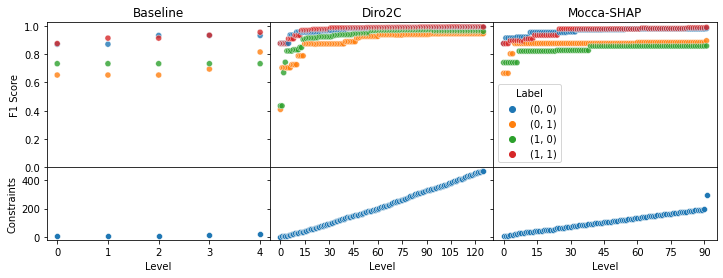

In [47]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*4, 4), sharex='col', sharey='row', gridspec_kw={'height_ratios': [2,1]})
for (approach, (grouped_metrics, constraints)), axs_col in zip(metrics_per_approach, axs.T):
    sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs_col[0], legend=approach == 'shap')
    sns.scatterplot(data=constraints, ax=axs_col[1])
    axs_col[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs_col[0].set_ylim((0, 1.025))
axs[0][0].set_title('Baseline')
axs[0][1].set_title('Diro2C')
axs[0][2].set_title('Mocca-SHAP')
plt.subplots_adjust(wspace=.0, hspace=.0)
plt.savefig('figures/bign-fidelity.pdf', bbox_inches='tight', pad_inches=0)

In [30]:
dict(metrics_per_approach)['shap'][0][-8:]

Label  Precision    Recall  F1 Score  Support  Nodes  Constraints  \
Level                                                                         
90    0  (0, 0)   0.984626  0.972941  0.978749   4213.0   36.0         63.0   
      1  (0, 1)   0.933333  0.836435  0.882231   1021.0    6.0         18.0   
      2  (1, 0)   0.942482  0.786195  0.857274   1188.0    5.0         15.0   
      3  (1, 1)   0.977711  0.993013  0.985302   3578.0   50.0         98.0   
91    0  (0, 0)   0.995604  0.967719  0.981464   4213.0   57.0         98.0   
      1  (0, 1)   0.987013  0.818805  0.895075   1021.0    9.0         27.0   
      2  (1, 0)   0.959417  0.776094  0.858074   1188.0    6.0         18.0   
      3  (1, 1)   0.987212  0.992454  0.989826   3578.0   78.0        154.0   

         Distance  
Level              
90    0  0.005412  
      1  0.380070  
      2  0.327986  
      3  0.000337  
91    0  0.000000  
      1  0.000000  
      2  0.000000  
      3  0.000000

In [37]:
dict(metrics_per_approach)['shap'][1][-2:]

Level
90    194.0
91    297.0
Name: Constraints, dtype: float64

In [33]:
dict(metrics_per_approach)['baseline'][0][-4:]

Label  Precision    Recall  F1 Score  Support  Leafs  Alpha  Rules  \
Level                                                                          
4     0  (0, 0)   0.900664  0.966295  0.932326   4213.0    8.0    0.0    2.0   
      1  (0, 1)   0.931990  0.724780  0.815427   1021.0    8.0    0.0    2.0   
      2  (1, 0)   0.826638  0.658249  0.732896   1188.0    8.0    0.0    1.0   
      3  (1, 1)   0.934492  0.976803  0.955179   3578.0    8.0    0.0    3.0   

         Constraints  
Level                 
4     0          4.0  
      1          7.0  
      2          3.0  
      3          7.0

In [34]:
dict(metrics_per_approach)['baseline'][1][-1:]

Level
4    21.0
Name: Constraints, dtype: float64

In [52]:
metrics = dict(metrics_per_approach)['diro2c']
constraints = metrics[1]
constraints = constraints[constraints <= 194][-1:]
constraints

Level
58    193.0
Name: Constraints, dtype: float64

In [53]:
metrics[0].loc[constraints.index, :]

Label  Precision    Recall  F1 Score  Support  Leafs     Alpha  \
Level                                                                      
58    0  (0, 0)   0.962471  0.998338  0.980077   4213.0   18.0  0.000247   
      1  (0, 1)   0.862944  0.999021  0.926010   1021.0   22.0  0.000271   
      2  (1, 0)   0.977625  0.956229  0.966809   1188.0   46.0  0.000268   
      3  (1, 1)   0.975690  0.998323  0.986877   3578.0   32.0  0.000301   

         Rules  Constraints  
Level                        
58    0    9.0         28.0  
      1    9.0         33.0  
      2   21.0         78.0  
      3   16.0         54.0

In [5]:
from explainers import plot_feature_dependence
import shap

In [6]:
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

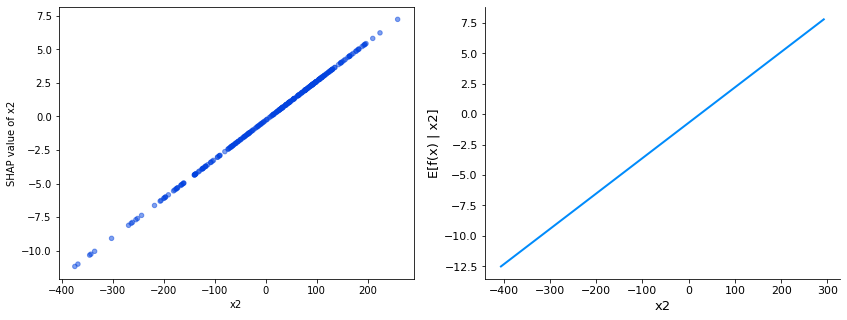

In [7]:
feature_idx, feature_name = comparer.check_feature('x2')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], feature_idx, alpha=0.5, ax=axs[0], show=False)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

In [8]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

In [9]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')

In [10]:
is_different = comparer.predict_bin_diff(X)

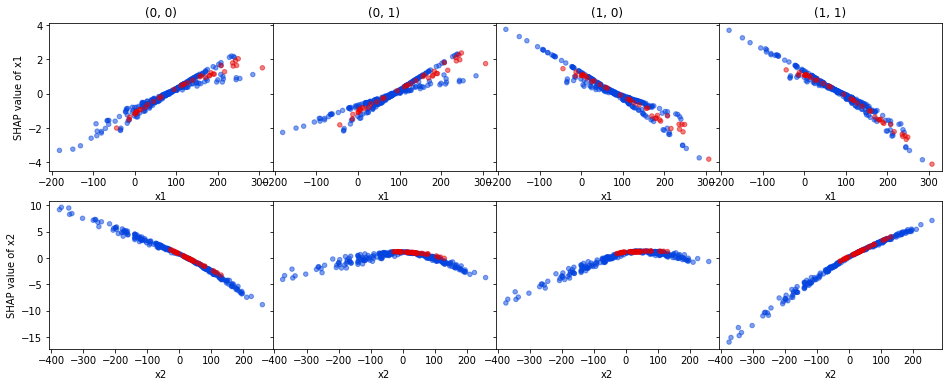

In [11]:
plot_feature_dependencies(shap_values, color=is_different, alpha=0.5, figsize=(4, 3))

In [12]:
feature_idx, feature_name = comparer.check_feature('x2')

SHAP Dependence Plot vs. PDP

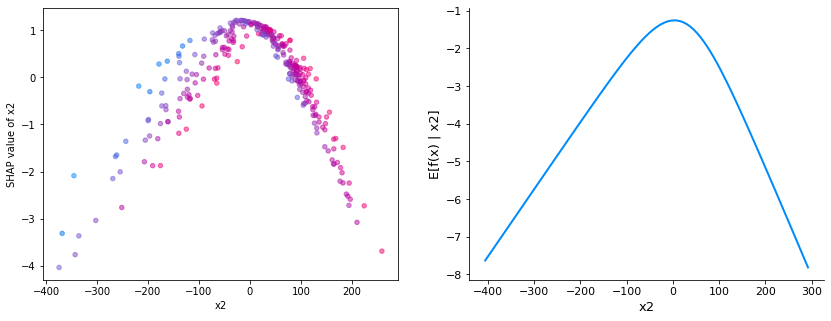

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False,
                        color=shap_values[:, 'x1', focus_class].data, color_label='x1')
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

In [14]:
from importlib import reload
import explainers
reload(explainers)
from explainers import *

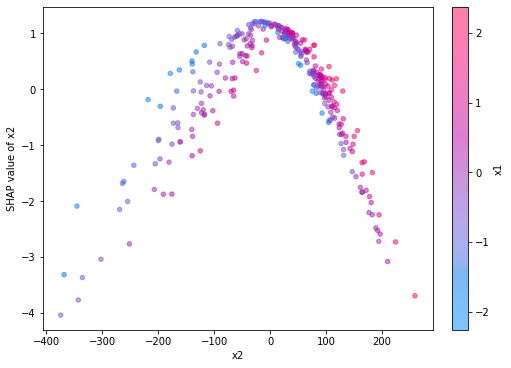

In [15]:
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5,
                        color=shap_values[:, 'x1', focus_class].values, color_label='x1')

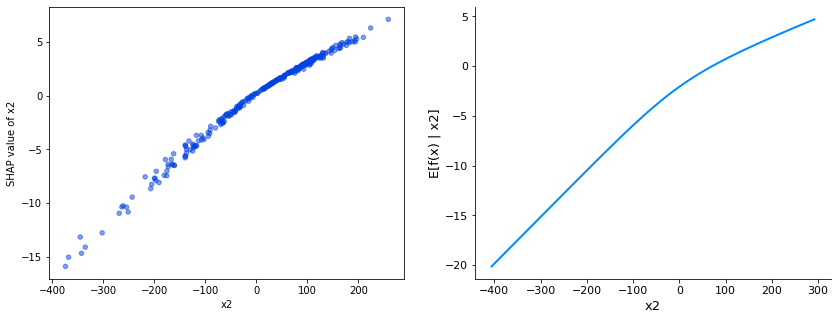

In [16]:
feature_idx, feature_name = comparer.check_feature('x2')
focus_class_idx, focus_class = comparer.check_class('(1, 1)')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

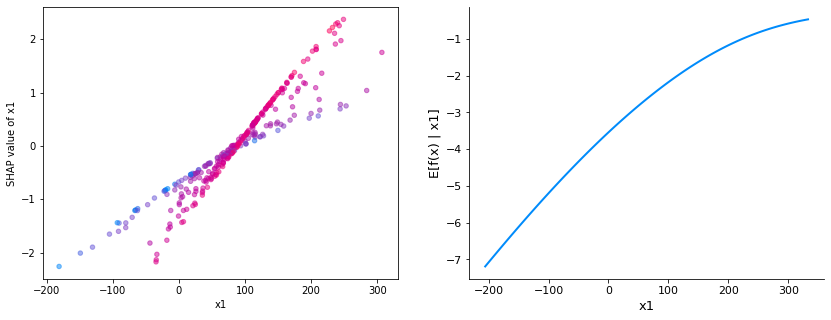

In [17]:
feature_idx, feature_name = comparer.check_feature('x1')
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False,
                        color=shap_values[:, 'x2', focus_class].data, color_label='x2')
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])